# Setup Iniziale




1.   Attivare il supporto GPU in Runtime->Change Runtime Type->Hardware Accelerator
2.   Check if pyCUDA è installato
3.   Cambia nome al notebook



In [1]:
import pycuda


ModuleNotFoundError: ignored

In [2]:
!pip install pycuda

     |████████████████████████████████| 1.7 MB 12.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 66 kB 4.1 MB/s 
     |████████████████████████████████| 75 kB 3.6 MB/s 
  Created wheel for pycuda: filename=pycuda-2021.1-cp37-cp37m-linux_x86_64.whl size=627219 sha256=001e17f42c28749872ac2e30c93b681d4da76e1734a6de7be84f7033bfc5fdbe
  Stored in directory: /root/.cache/pip/wheels/c4/ef/49/dc6a5feb8d980b37c83d465ecab24949a6aa19458522a9e001
  Created wheel for pytools: filename=pytools-2021.2.9-py2.py3-none-any.whl size=62370 sha256=7792d49a3d1b9bc98f327ab4dd737a7681c486ff86cf2c2960d88d993d09133b
  Stored in directory: /root/.cache/pip/wheels/41/b9/6e/94bb014f6484b15ec77e7877f3a227609481ffd98db364504d
Successfully built pycuda pytools


In [3]:
import pycuda



4.   Controlla la versione di CUDA installata



In [4]:
!nvcc --version 

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


# Esplorare la Bash

In [5]:
!ls

sample_data


In [6]:
mkdir test_dir

In [7]:
cd test_dir

/content/test_dir


In [8]:
ls

In [9]:
!touch ciao

In [10]:
ls

ciao


In [11]:
rm ciao

In [12]:
ls

In [13]:
pwd

'/content/test_dir'

In [14]:
cd ..


/content


In [15]:
!gcc --version

gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



# Caratteristiche della GPU in uso

Proviamo a capire le caratteristiche della GPU che abbiamo a disposizione.


In [16]:
!nvidia-smi

Tue Nov  2 13:22:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

oppure si può usare il modulo pycuda, interrogando le funzioni del driver

In [17]:
import pycuda.driver as drv
drv.init()
drv.get_version()
devn=drv.Device.count()
print("N GPU "+str(devn))
devices = []
for i in range(devn):
  devices.append(drv.Device(i))
for sp in devices:
  print("GPU name: "+str(sp.name))
  print("Compute Capability = "+str(sp.compute_capability()))
  print("Total Memory = "+str(sp.total_memory()/(2.**20))+' MBytes')
  attr = sp.get_attributes()
  print(attr)

N GPU 1
GPU name: <bound method name of <pycuda._driver.Device object at 0x7f5d8bf832f0>>
Compute Capability = (3, 7)
Total Memory = 11441.1875 MBytes
{pycuda._driver.device_attribute.ASYNC_ENGINE_COUNT: 2, pycuda._driver.device_attribute.CAN_MAP_HOST_MEMORY: 1, pycuda._driver.device_attribute.CLOCK_RATE: 823500, pycuda._driver.device_attribute.COMPUTE_CAPABILITY_MAJOR: 3, pycuda._driver.device_attribute.COMPUTE_CAPABILITY_MINOR: 7, pycuda._driver.device_attribute.COMPUTE_MODE: pycuda._driver.compute_mode.DEFAULT, pycuda._driver.device_attribute.CONCURRENT_KERNELS: 1, pycuda._driver.device_attribute.ECC_ENABLED: 1, pycuda._driver.device_attribute.GLOBAL_L1_CACHE_SUPPORTED: 1, pycuda._driver.device_attribute.GLOBAL_MEMORY_BUS_WIDTH: 384, pycuda._driver.device_attribute.GPU_OVERLAP: 1, pycuda._driver.device_attribute.INTEGRATED: 0, pycuda._driver.device_attribute.KERNEL_EXEC_TIMEOUT: 0, pycuda._driver.device_attribute.L2_CACHE_SIZE: 1572864, pycuda._driver.device_attribute.LOCAL_L1_CACHE

oppure anche con il metodo DeviceData()

In [18]:
from pycuda import autoinit
from pycuda.tools import DeviceData
specs = DeviceData()
print ('Max threads per block = '+str(specs.max_threads))
print ('Warp size            ='+str(specs.warp_size))
print ('Warps per MP         ='+str(specs.warps_per_mp))
print ('Thread Blocks per MP ='+str(specs.thread_blocks_per_mp))
print ('Registers            ='+str(specs.registers))
print ('Shared memory        ='+str(specs.shared_memory))

Max threads per block = 1024
Warp size            =32
Warps per MP         =64
Thread Blocks per MP =8
Registers            =65536
Shared memory        =49152


# Esempio GPU in C
(comunque ci servirà dopo)
Proviamo a scrivere e compulare un programma GPU in C. Notare il comando (magic) all'inizio che serve per salvare nel workspace il contenuto della cella in un file

In [57]:
%%writefile VecAdd.cu
# include <stdio.h>
# include <cuda_runtime.h>
// CUDA Kernel
__global__ void vectorAdd(const float *A, const float *B, float *C, int numElements)
{
    int i = blockDim.x * blockIdx.x + threadIdx.x;
    if (i < numElements)
    {
        C[i] = A[i] + B[i];
    }
}
 
/**
 * Host main routine
 */
int main(void)
{
    int numElements = 15;
    size_t size = numElements * sizeof(float);
    printf("[Vector addition of %d elements]\n", numElements);
 
    float a[numElements],b[numElements],c[numElements];
    float *a_gpu,*b_gpu,*c_gpu;
 
    cudaMalloc((void **)&a_gpu, size);
    cudaMalloc((void **)&b_gpu, size);
    cudaMalloc((void **)&c_gpu, size);
 
    for (int i=0;i<numElements;++i ){
 
        a[i] = i*i;
        b[i] = i;
 
    }
    // Copy the host input vectors A and B in host memory to the device input vectors in
    // device memory
    printf("Copy input data from the host memory to the CUDA device\n");
    cudaMemcpy(a_gpu, a, size, cudaMemcpyHostToDevice);
    cudaMemcpy(b_gpu, b, size, cudaMemcpyHostToDevice);
 
    // Launch the Vector Add CUDA Kernel
    int threadsPerBlock = 256;
    int blocksPerGrid =(numElements + threadsPerBlock - 1) / threadsPerBlock;
    printf("CUDA kernel launch with %d blocks of %d threads\n", blocksPerGrid, threadsPerBlock);
    vectorAdd<<<blocksPerGrid, threadsPerBlock>>>(a_gpu, b_gpu, c_gpu, numElements);
 
    // Copy the device result vector in device memory to the host result vector
    // in host memory.
    printf("Copy output data from the CUDA device to the host memory\n");
    cudaMemcpy(c, c_gpu, size, cudaMemcpyDeviceToHost);
 
    for (int i=0;i<numElements;++i ){
        printf("%f \n",c[i]);
    }
 
    // Free device global memory
    cudaFree(a_gpu);
    cudaFree(b_gpu);
    cudaFree(c_gpu);
 
    printf("Done\n");
    return 0;
}


Overwriting VecAdd.cu


In [58]:
ls

sample_data/  test_dir/  VecAdd*  VecAdd.cu


In [78]:
!nvcc -o VecAdd VecAdd.cu -arch=compute_35 -code=sm_35





nvcc warning : The 'compute_35', 'compute_37', 'compute_50', 'sm_35', 'sm_37' and 'sm_50' architectures are deprecated, and may be removed in a future release (Use -Wno-deprecated-gpu-targets to suppress warning).


In [79]:
!./VecAdd

[Vector addition of 15 elements]
Copy input data from the host memory to the CUDA device
CUDA kernel launch with 1 blocks of 256 threads
Copy output data from the CUDA device to the host memory
0.000000 
2.000000 
6.000000 
12.000000 
20.000000 
30.000000 
42.000000 
56.000000 
72.000000 
90.000000 
110.000000 
132.000000 
156.000000 
182.000000 
210.000000 
Done


# Implementazione con pycuda
Facciamo un primo esempio con pycuda

importiamo i moduli ch eci servono

In [61]:
from pycuda import autoinit
from pycuda import gpuarray
import numpy as np

definiamo i vettori a, b e c sull'host. Tutti di lunghezza 15, a con i numeri da 0..14 e b con i quadrati. c è inizializzato a 0

In [62]:
aux = range(15)
a = np.array(aux).astype(np.float32)
b = (a*a).astype(np.float32)
c = np.zeros(len(aux)).astype(np.float32)

Definiamo i vettori sulla GPU e copiamo dentro il contenuto dei vettori a,b e c definiti sull'host

In [63]:
a_gpu = gpuarray.to_gpu(a)
b_gpu = gpuarray.to_gpu(b)
c_gpu = gpuarray.to_gpu(c)

un primo modo semplice per sommare i vettori e semplicemente usare il +

In [64]:
c_gpu=a_gpu+b_gpu

/usr/local/lib/python3.7/dist-packages/pycuda/elementwise.py:82: UserWarning: The CUDA compiler succeeded, but said the following:
nvcc warning : The 'compute_35', 'compute_37', 'compute_50', 'sm_35', 'sm_37' and 'sm_50' architectures are deprecated, and may be removed in a future release (Use -Wno-deprecated-gpu-targets to suppress warning).

  no_extern_c=True,


stampiamo i risultati

In [65]:
print(c_gpu)

[  0.   2.   6.  12.  20.  30.  42.  56.  72.  90. 110. 132. 156. 182.
 210.]


In [66]:
c_gpu

array([  0.,   2.,   6.,  12.,  20.,  30.,  42.,  56.,  72.,  90., 110.,
       132., 156., 182., 210.], dtype=float32)

Un secondo modo è quello di utilizzre il metodo elementwise, che applicala stessa "Operation" a tutti gli elementi dei vettori

In [67]:
from pycuda.elementwise import ElementwiseKernel
myCudaFunc = ElementwiseKernel(arguments = "float *a, float *b, float *c",
                               operation = "c[i] = a[i]+b[i]",
                               name = "mySumK")

In [68]:
myCudaFunc(a_gpu,b_gpu,c_gpu)

/usr/local/lib/python3.7/dist-packages/pycuda/elementwise.py:82: UserWarning: The CUDA compiler succeeded, but said the following:
nvcc warning : The 'compute_35', 'compute_37', 'compute_50', 'sm_35', 'sm_37' and 'sm_50' architectures are deprecated, and may be removed in a future release (Use -Wno-deprecated-gpu-targets to suppress warning).

  no_extern_c=True,


In [69]:
c_gpu

array([  0.,   2.,   6.,  12.,  20.,  30.,  42.,  56.,  72.,  90., 110.,
       132., 156., 182., 210.], dtype=float32)

Il vantaggio è che si possono definire anche operazioni piu' complesse della semplice somma, ad esempio

In [70]:
from pycuda.elementwise import ElementwiseKernel
lin_comb = ElementwiseKernel(
        "float a, float *x, float b, float *y, float *z",
        "z[i] = a*x[i] + b*y[i]",
        "linear_combination")

In [71]:
lin_comb(3.,a_gpu,5.,b_gpu,c_gpu)

/usr/local/lib/python3.7/dist-packages/pycuda/elementwise.py:82: UserWarning: The CUDA compiler succeeded, but said the following:
nvcc warning : The 'compute_35', 'compute_37', 'compute_50', 'sm_35', 'sm_37' and 'sm_50' architectures are deprecated, and may be removed in a future release (Use -Wno-deprecated-gpu-targets to suppress warning).

  no_extern_c=True,


In [80]:
c_gpu

array([   0.,    8.,   26.,   54.,   92.,  140.,  198.,  266.,  344.,
        432.,  530.,  638.,  756.,  884., 1022.], dtype=float32)

Il terzo metodo è il piu' "generico". SI utilizza il mtodo SourceModule che permette di definire anche kernel piu' complessi. L'idea è che questi kernel siano comunque scritti in Cuda/C

In [81]:
from pycuda.compiler import SourceModule


carichiamo il file contenente il codice in c che avevamo scritto prima (fare !ls se avete dubbi sul nome che gli avete dato)

In [82]:
!ls


sample_data  test_dir  VecAdd  VecAdd.cu


In [83]:
cudaCode = open("VecAdd.cu","r")
myCUDACode = cudaCode.read()

compiliamo il codice just-in-time con il metodo SourceModule()

In [84]:
myCode = SourceModule(myCUDACode)

ora il kernel (e l'host) è compilato. Importiamolo nel programma in python

In [85]:
importedKernel = myCode.get_function("vectorAdd")


definiamo la "geometria" della GPU che vogliamo usare

In [86]:
nThreadsPerBlock = 256
nBlockPerGrid = 1
nGridsPerBlock = 1

resettiamo il vettore c_gpu (per essere sicuri sia vuoto)

In [87]:
c_gpu.set(c)
c_gpu

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

Il puntatore nella memoria gpu è dato dall'attributo gpudata

In [88]:
a_gpu.gpudata

In [89]:
b_gpu.gpudata

lanciamo il kernel importato passandogli i puntatori dei vettori e la geometria della GPU

In [90]:
importedKernel(a_gpu.gpudata, b_gpu.gpudata, c_gpu.gpudata, block=(nThreadsPerBlock,nBlockPerGrid,nGridsPerBlock))

In [91]:
c_gpu

array([  0.,   2.,   6.,  12.,  20.,  30.,  42.,  56.,  72.,  90., 110.,
       132., 156., 182., 210.], dtype=float32)

# Somma di Matrici

Puliamo la memoria

In [92]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


importiamo le cose che ci servono

In [93]:
import numpy as np
from pycuda import gpuarray, autoinit
import pycuda.driver as cuda
from pycuda.tools import DeviceData
from pycuda.tools import OccupancyRecord as occupancy

inizializziamo gli array con le dimensioni appropriate

In [94]:
presCPU, presGPU = np.float32, 'float'
#presCPU, presGPU = np.float64, 'double'
a_cpu = np.random.random((512,512)).astype(presCPU)
b_cpu = np.random.random((512,512)).astype(presCPU)
c_cpu = np.zeros((512,512), dtype=presCPU)

carichiamo matplotlib per poterlo usare nella Ipython

In [95]:
%matplotlib inline

In [96]:
from matplotlib import pyplot as plt

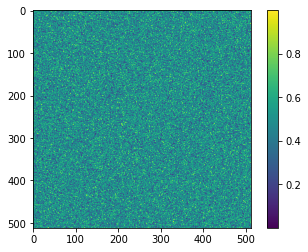

In [97]:
plt.imshow(a_cpu)
plt.colorbar()

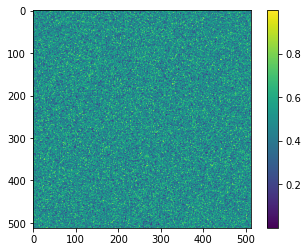

In [100]:
plt.imshow(b_cpu)
plt.colorbar()

copiamo gli array sulla gpu

In [101]:
a_gpu = gpuarray.to_gpu(a_cpu)
b_gpu = gpuarray.to_gpu(b_cpu)
c_gpu = gpuarray.to_gpu(c_cpu)

In [102]:
c_gpu

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

facciamo la somma prima sull'host

In [103]:
c_cpu=a_cpu+b_cpu

In [104]:
c_cpu

array([[1.4112753 , 1.2518631 , 1.2007344 , ..., 0.7026706 , 1.0260177 ,
        1.2954998 ],
       [0.72781694, 1.3540971 , 0.8865615 , ..., 0.5551844 , 0.6183413 ,
        0.97855496],
       [0.2328592 , 1.7011247 , 0.38032082, ..., 0.171897  , 0.98802435,
        0.93404245],
       ...,
       [0.3416177 , 1.7463468 , 1.4162972 , ..., 1.6910913 , 0.4443923 ,
        0.6984018 ],
       [0.85813427, 1.0422938 , 1.0257807 , ..., 0.67897946, 0.03942119,
        0.6666572 ],
       [0.5858137 , 0.8593012 , 0.60153323, ..., 1.2110431 , 0.93383515,
        0.62613416]], dtype=float32)

misuriamo il tempo che ci vuole sull'host per fare la somma

In [105]:
t_cpu = %timeit -o c_cpu = a_cpu+b_cpu

1000 loops, best of 5: 200 µs per loop


definiamo il kernel gpu per fare la somma

In [106]:
cudaKernel = '''
__global__ void matrixAdd(float *A, float *B, float *C)
{
    int tid_x = blockDim.x * blockIdx.x + threadIdx.x;
    int tid_y = blockDim.y * blockIdx.y + threadIdx.y;
    int tid   = gridDim.x * blockDim.x * tid_y + tid_x;
    C[tid] = A[tid] + B[tid];
}
'''

ora dobbiamo compilare questo kernel e generare la funzione da usare in python

In [107]:
from pycuda.compiler import SourceModule
myCode = SourceModule(cudaKernel)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: The CUDA compiler succeeded, but said the following:
nvcc warning : The 'compute_35', 'compute_37', 'compute_50', 'sm_35', 'sm_37' and 'sm_50' architectures are deprecated, and may be removed in a future release (Use -Wno-deprecated-gpu-targets to suppress warning).

  


In [108]:
addMatrix = myCode.get_function("matrixAdd") # The output of get_function is the GPU-compiled function.

In [109]:
type(addMatrix)

pycuda._driver.Function

dobbiamo decidere la geoemtria della GPU. Ad esempio si possono cercare di sfruttare tutt i threads a disposizione in un blocco. Quati thread ci sono in un blocco?

In [110]:
dev = cuda.Device(0)
devdata = DeviceData(dev)
print ("Using device : "+dev.name() )
print("Max threads per block: "+str(dev.max_threads_per_multiprocessor))

Using device : Tesla K80
Max threads per block: 2048


Quindi possiamo usare blocchi 32x32. Le nostre matrici sono 512x512, per cui dobbiamo usare 16x16 blocchi

In [111]:
cuBlock = (32,32,1)
cuGrid = (16,16,1)

abbiamo già compilato il kernel con SourceModule. Ora abbiamo due modi per lanciarlo. O chiamiamo direttamente la funzione (come abbiamo fatto sopra per la somam di vettori)
```
kernelFunction(arg1,arg2, ... ,block=(n,m,l),grid=(r,s,t)
```
oppure usiamo la "preparation"


```
kernelFunction.prepare('ABC..') # Each letter corresponds to an input data type of the function, i = int, f = float, P = pointer, ...
kernelFunction.prepared_call(grid,block,arg1.gpudata,arg2,...) # When using GPU arrays, they should be passed as pointers with the attribute 'gpudata'
```






il primo metodo è, per noi


In [112]:
addMatrix(a_gpu,b_gpu,c_gpu,block=cuBlock,grid=cuGrid)

con la preparation è possibile midurare il tempo di esecuzione

In [113]:
addMatrix.prepare('PPP')
addMatrix.prepared_call(cuGrid,cuBlock,a_gpu.gpudata,b_gpu.gpudata,c_gpu.gpudata)

In [114]:
time2 = addMatrix.prepared_timed_call(cuGrid,cuBlock,a_gpu.gpudata,b_gpu.gpudata,c_gpu.gpudata)

In [115]:
time2()

0.00014396800100803376

per controllare il risultato dobbiamo copiare il risultato dalla gpu alla cpu

In [116]:
c = c_gpu.get()

controlliamo il risultato per cpu e gpu

In [117]:
c, c_cpu

(array([[1.4112753 , 1.2518631 , 1.2007344 , ..., 0.7026706 , 1.0260177 ,
         1.2954998 ],
        [0.72781694, 1.3540971 , 0.8865615 , ..., 0.5551844 , 0.6183413 ,
         0.97855496],
        [0.2328592 , 1.7011247 , 0.38032082, ..., 0.171897  , 0.98802435,
         0.93404245],
        ...,
        [0.3416177 , 1.7463468 , 1.4162972 , ..., 1.6910913 , 0.4443923 ,
         0.6984018 ],
        [0.85813427, 1.0422938 , 1.0257807 , ..., 0.67897946, 0.03942119,
         0.6666572 ],
        [0.5858137 , 0.8593012 , 0.60153323, ..., 1.2110431 , 0.93383515,
         0.62613416]], dtype=float32),
 array([[1.4112753 , 1.2518631 , 1.2007344 , ..., 0.7026706 , 1.0260177 ,
         1.2954998 ],
        [0.72781694, 1.3540971 , 0.8865615 , ..., 0.5551844 , 0.6183413 ,
         0.97855496],
        [0.2328592 , 1.7011247 , 0.38032082, ..., 0.171897  , 0.98802435,
         0.93404245],
        ...,
        [0.3416177 , 1.7463468 , 1.4162972 , ..., 1.6910913 , 0.4443923 ,
         0.6984018 

per confrontare meglio, guardiamo i plot

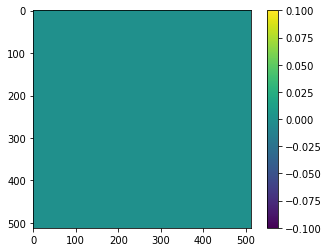

In [118]:
plt.imshow(c-c_cpu,interpolation='none')
plt.colorbar()

In [119]:
np.sum(np.sum(np.abs(c_cpu-c)))

0.0

in effetti i risultati sono uguali

# Moltiplicazione tra matrici

scriviamo un kernel per la moltiplicazione di matrici

In [120]:
cudaKernel2 = '''
__global__ void matrixMul(float *A, float *B, float *C)
{
    int tid_x = blockDim.x * blockIdx.x + threadIdx.x; // Row
    int tid_y = blockDim.y * blockIdx.y + threadIdx.y; // Column
    int matrixDim = gridDim.x * blockDim.x;
    int tid   = matrixDim * tid_y + tid_x; // element i,j
    
    float  aux=0.0f;
    
    for ( int i=0 ; i<matrixDim ; i++ ){
        //          
        aux += A[matrixDim * tid_y + i]*B[matrixDim * i + tid_x] ;
    
    }
    
    C[tid] = aux;
             
}
'''

compiliamo e importiamo con SourceModule

In [121]:
myCode = SourceModule(cudaKernel2)
mulMatrix = myCode.get_function("matrixMul")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: The CUDA compiler succeeded, but said the following:
nvcc warning : The 'compute_35', 'compute_37', 'compute_50', 'sm_35', 'sm_37' and 'sm_50' architectures are deprecated, and may be removed in a future release (Use -Wno-deprecated-gpu-targets to suppress warning).

  """Entry point for launching an IPython kernel.


eseguiamolo con la stessa struttura a blocchi definite per la somma di matrici

In [122]:
mulMatrix(a_gpu,b_gpu,c_gpu,block=cuBlock,grid=cuGrid)

sulla CPU sarà invece

In [123]:
dotAB = np.dot(a_cpu, b_cpu)

vediamo il risultato è lo stesso

In [124]:
diff = np.abs(c_gpu.get()-dotAB)
np.sum(diff)

8.577576

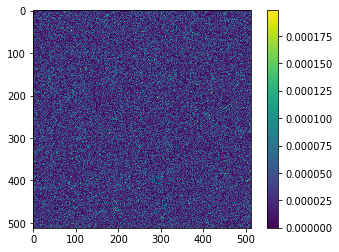

In [125]:
plt.imshow(diff,interpolation='none')
plt.colorbar()

In [126]:
dotAB

array([[128.77496 , 130.86583 , 129.45001 , ..., 128.73799 , 130.7213  ,
        126.464165],
       [135.86154 , 131.79364 , 135.95311 , ..., 138.80406 , 135.34535 ,
        134.05887 ],
       [130.86789 , 132.87238 , 132.7431  , ..., 131.04312 , 131.49377 ,
        129.69724 ],
       ...,
       [124.5096  , 123.917984, 127.824295, ..., 129.38472 , 128.08453 ,
        124.080765],
       [128.13954 , 127.34018 , 130.03752 , ..., 129.59583 , 127.6555  ,
        128.61241 ],
       [129.73077 , 129.0686  , 129.58684 , ..., 129.79431 , 129.64424 ,
        128.86961 ]], dtype=float32)

In [127]:
c_gpu

array([[128.77498, 130.86584, 129.45007, ..., 128.73795, 130.7213 ,
        126.46414],
       [135.86154, 131.79364, 135.95323, ..., 138.804  , 135.34537,
        134.0588 ],
       [130.86789, 132.87242, 132.74307, ..., 131.04308, 131.49379,
        129.69722],
       ...,
       [124.50953, 123.91793, 127.82426, ..., 129.38475, 128.08458,
        124.08083],
       [128.13962, 127.34019, 130.0375 , ..., 129.59589, 127.6555 ,
        128.61241],
       [129.73082, 129.06863, 129.58682, ..., 129.79436, 129.64427,
        128.86961]], dtype=float32)

In [128]:
presCPU, presGPU = np.float64, 'double'
a_cpu = np.random.random((512,512)).astype(presCPU)
b_cpu = np.random.random((512,512)).astype(presCPU)
c_cpu = np.zeros((512,512), dtype=presCPU)

In [129]:
a_gpu = gpuarray.to_gpu(a_cpu)
b_gpu = gpuarray.to_gpu(b_cpu)
c_gpu = gpuarray.to_gpu(c_cpu)

In [130]:
a_cpu.dtype

dtype('float64')

In [131]:
cudaKernel3 = '''
__global__ void matrixMul64(double *A, double *B, double *C)
{
    int tid_x = blockDim.x * blockIdx.x + threadIdx.x; // Row
    int tid_y = blockDim.y * blockIdx.y + threadIdx.y; // Column
    int matrixDim = gridDim.x * blockDim.x;
    int tid   = matrixDim * tid_y + tid_x; // element i,j
    
    double aux = 0.0;
    for ( int i=0 ; i<matrixDim ; i++ ){
        //          
        aux += A[matrixDim * tid_y + i]*B[matrixDim * i + tid_x] ;
    
    }
    
    C[tid] = aux;
             
}
'''

In [132]:
myCode64 = SourceModule(cudaKernel3)
mulMatrix64 = myCode64.get_function("matrixMul64")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: The CUDA compiler succeeded, but said the following:
nvcc warning : The 'compute_35', 'compute_37', 'compute_50', 'sm_35', 'sm_37' and 'sm_50' architectures are deprecated, and may be removed in a future release (Use -Wno-deprecated-gpu-targets to suppress warning).

  """Entry point for launching an IPython kernel.


In [133]:
mulMatrix64(a_gpu,b_gpu,c_gpu,block=cuBlock,grid=cuGrid)

In [134]:
dotAB = np.dot(a_cpu, b_cpu)

In [135]:
c_gpu.dtype

dtype('float64')

In [136]:
dotAB.dtype

dtype('float64')

In [137]:
diff = np.abs(c_gpu.get()-dotAB)


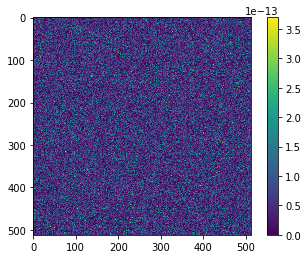

In [138]:
plt.imshow(diff,interpolation='none')
plt.colorbar()

# Ancora sulla somma di vettori

In [139]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


Vogliamo confrontare i tempi per la somma di vettori di dimensione variabile, tra CPU e GPU

Iniziamo con la versione CPU

In [140]:
%matplotlib inline
from matplotlib import pyplot as plt

In [141]:
import numpy as np

In [142]:
from time import time
def myColorRand():
    return (np.random.random(),np.random.random(),np.random.random())

In [143]:
dimension = [2**i for i in range(5,25) ]
myPrec = np.float32

In [144]:
dimension

[32,
 64,
 128,
 256,
 512,
 1024,
 2048,
 4096,
 8192,
 16384,
 32768,
 65536,
 131072,
 262144,
 524288,
 1048576,
 2097152,
 4194304,
 8388608,
 16777216]

In [145]:
nLoops = 100
timeCPU = []
for n in dimension:
    v1_cpu = np.random.random(n).astype(myPrec)
    v2_cpu = np.random.random(n).astype(myPrec)
    tMean = 0
    for i in range(nLoops):
        t = time() 
        v = v1_cpu+v2_cpu
        t = time() - t
        tMean += t/nLoops
    timeCPU.append(tMean)

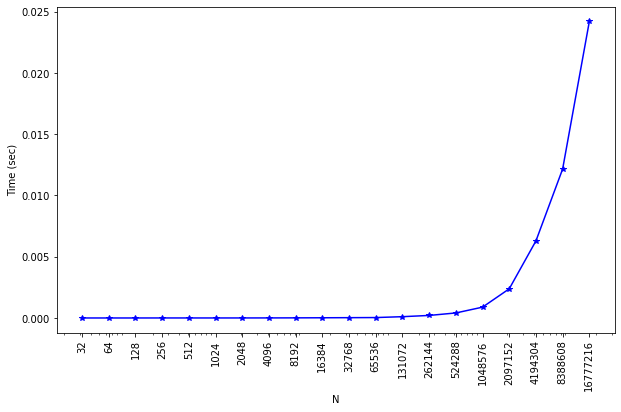

In [146]:
plt.figure(1,figsize=(10,6))
plt.semilogx(dimension,timeCPU,'b-*')
plt.ylabel('Time (sec)')
plt.xlabel('N')
plt.xticks(dimension, dimension, rotation='vertical')
plt.show()

Proviamo a fare la versione GPU

Per prima cosa guardiamo la semplice somma (primo metodo)

In [147]:
import pycuda
from pycuda import gpuarray

In [148]:
timeGPU1 = []
bandWidth1 = []
for n in dimension:
    v1_cpu = np.random.random(n).astype(myPrec)
    v2_cpu = np.random.random(n).astype(myPrec)
    t1Mean = 0
    t2Mean = 0
    for i in range(nLoops):
        t = time()
        vaux = gpuarray.to_gpu(v1_cpu)
        t = time() -t
        t1Mean += t/nLoops
    bandWidth1.append(t1Mean)
    v1_gpu = gpuarray.to_gpu(v1_cpu) 
    v2_gpu = gpuarray.to_gpu(v2_cpu)
    for i in range(nLoops):
        t = time()
        v = v1_gpu+v2_gpu
        t = time() -t
        t2Mean += t/nLoops
    timeGPU1.append(t2Mean)
    v1_gpu.gpudata.free()
    v2_gpu.gpudata.free()
    v.gpudata.free()

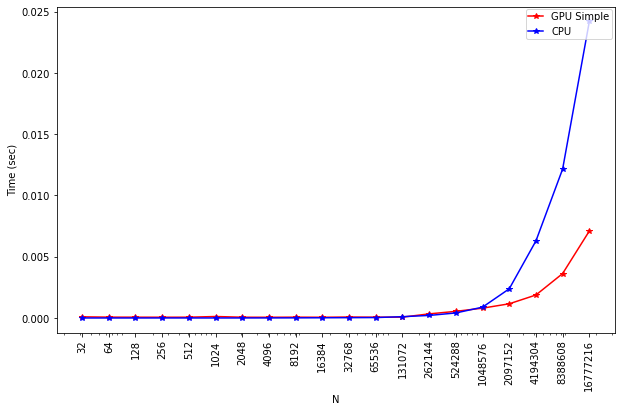

In [149]:
plt.figure(1,figsize=(10,6))
plt.semilogx(dimension,timeGPU1,'r-*',label='GPU Simple')
plt.semilogx(dimension,timeCPU,'b-*',label='CPU')
plt.ylabel('Time (sec)')
plt.xlabel('N')
plt.xticks(dimension, dimension, rotation='vertical')
plt.legend(loc=1,labelspacing=0.5,fancybox=True, handlelength=1.5, borderaxespad=0.25, borderpad=0.25)
plt.show()

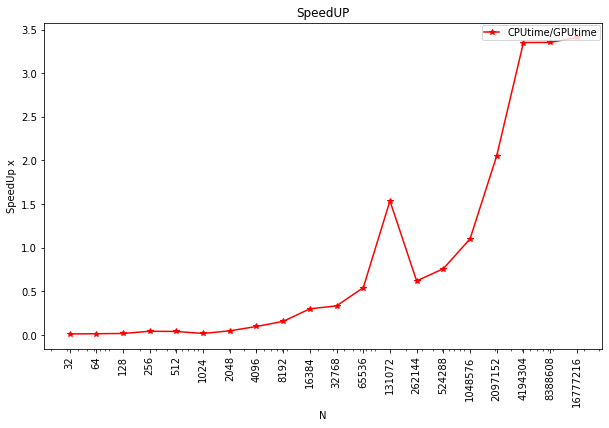

In [150]:
plt.figure(1,figsize=(10,6))

a = np.array(timeGPU1)
b = np.array(timeCPU)
plt.semilogx(dimension,b/a,'r-*',label='CPUtime/GPUtime')
plt.ylabel('SpeedUp x')
plt.xlabel('N')
plt.title('SpeedUP')
plt.xticks(dimension, dimension, rotation='vertical')
plt.legend(loc=1,labelspacing=0.5,fancybox=True, handlelength=1.5, borderaxespad=0.25, borderpad=0.25)
plt.show()

proviamo anche a valutare il tempo di trasferimento su GPU

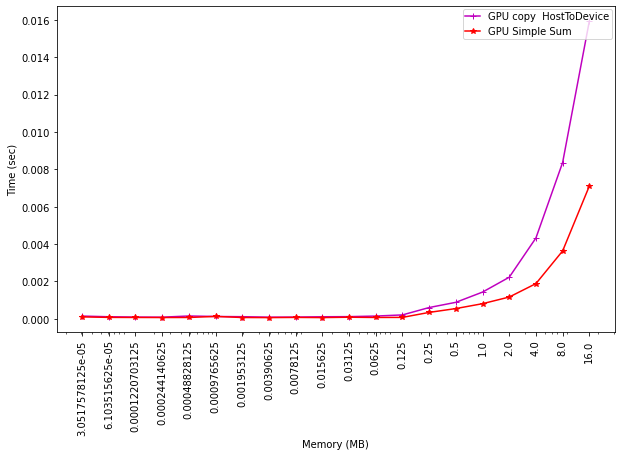

In [151]:
plt.figure(1,figsize=(10,6))
sizeMB = np.array(dimension)/(2.**20)
plt.semilogx(sizeMB,bandWidth1,'m-+',label='GPU copy  HostToDevice')
plt.semilogx(sizeMB,timeGPU1,'r-*',label='GPU Simple Sum')
plt.ylabel('Time (sec)')
plt.xlabel('Memory (MB)')
plt.xticks(sizeMB, sizeMB, rotation='vertical')
plt.legend(loc=1,labelspacing=0.5,fancybox=True, handlelength=1.5, borderaxespad=0.25, borderpad=0.25)
plt.show()

proviamo ad usare elementwise (secondo metodo)

In [152]:
from pycuda.elementwise import ElementwiseKernel
myCudaFunc = ElementwiseKernel(arguments = "float *a, float *b, float *c",
                               operation = "c[i] = a[i]+b[i]",
                               name = "mySumK")

In [153]:
import pycuda.driver as drv
start = drv.Event()
end = drv.Event()

In [154]:
timeGPU2 = []
for n in dimension:
    v1_cpu = np.random.random(n).astype(myPrec)
    v2_cpu = np.random.random(n).astype(myPrec)
    v1_gpu = gpuarray.to_gpu(v1_cpu) 
    v2_gpu = gpuarray.to_gpu(v2_cpu)
    vr_gpu  = gpuarray.to_gpu(v2_cpu)
    t3Mean=0
    for i in range(nLoops):
        start.record()
        myCudaFunc(v1_gpu,v2_gpu,vr_gpu)
        end.record()
        end.synchronize()
        secs = start.time_till(end)*1e-3
        t3Mean+=secs/nLoops
    timeGPU2.append(t3Mean)
    v1_gpu.gpudata.free()
    v2_gpu.gpudata.free()
    vr_gpu.gpudata.free()

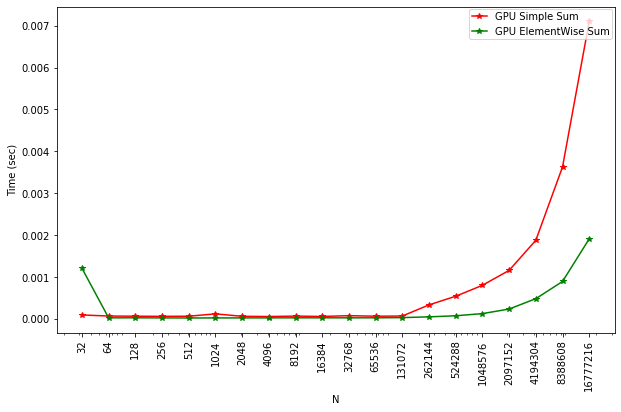

In [155]:
plt.figure(1,figsize=(10,6))
plt.semilogx(dimension,timeGPU1,'r-*',label='GPU Simple Sum')
plt.semilogx(dimension,timeGPU2,'g-*',label='GPU ElementWise Sum')
plt.ylabel('Time (sec)')
plt.xlabel('N')
plt.xticks(dimension, dimension, rotation='vertical')
plt.legend(loc=1,labelspacing=0.5,fancybox=True, handlelength=1.5, borderaxespad=0.25, borderpad=0.25)

Implementazione con SourceModule. E' possibile variare la geometria di griglia e blocchi

In [156]:
from pycuda.compiler import SourceModule

In [157]:
presCPU, presGPU = np.float32, 'float'
cudaCode = open("VecAdd.cu","r")
cudaCode = cudaCode.read()
cudaCode = cudaCode.replace('float',presGPU )
myCode = SourceModule(cudaCode)
vectorAddKernel = myCode.get_function("vectorAdd")
vectorAddKernel.prepare('PPP')

In [159]:
timeGPU3 = []
occupancyMesure=[]
for nt in [32,64,128,256,512,1024]:
    aux = []
    auxOcc = []
    for n in dimension:
        v1_cpu = np.random.random(n).astype(myPrec)
        v2_cpu = np.random.random(n).astype(myPrec)
        v1_gpu = gpuarray.to_gpu(v1_cpu) 
        v2_gpu = gpuarray.to_gpu(v2_cpu)
        vr_gpu  = gpuarray.to_gpu(v2_cpu)
        cudaBlock = (nt,1,1) 
        cudaGrid    = (int((n+nt-1)/nt),1,1)
        
        cudaCode = open("VecAdd.cu","r")
        cudaCode = cudaCode.read()
        cudaCode = cudaCode.replace('float',presGPU )
        downVar = ['blockDim.x','blockDim.y','blockDim.z','gridDim.x','gridDim.y','gridDim.z']
        upVar      = [str(cudaBlock[0]),str(cudaBlock[1]),str(cudaBlock[2]),
                     str(cudaGrid[0]),str(cudaGrid[1]),str(cudaGrid[2])]
        dicVarOptim = dict(zip(downVar,upVar))
        for i in downVar:
            cudaCode = cudaCode.replace(i,dicVarOptim[i])
        #print cudaCode
        myCode = SourceModule(cudaCode)
        vectorAddKernel = myCode.get_function("vectorAdd")
        vectorAddKernel.prepare('PPP')
        
        print ('Size= '+str(n)+" threadsPerBlock= "+str(nt))
        print (str(cudaBlock)+" "+str(cudaGrid))
        t5Mean = 0
        for i in range(nLoops):
            timeAux = vectorAddKernel.prepared_timed_call(cudaGrid,cudaBlock,v1_gpu.gpudata,v2_gpu.gpudata,vr_gpu.gpudata)
            t5Mean += timeAux()/nLoops
        aux.append(t5Mean)
        v1_gpu.gpudata.free()
        v2_gpu.gpudata.free()
        vr_gpu.gpudata.free()
    timeGPU3.append(aux)
    occupancyMesure.append(auxOcc)

Size= 32 threadsPerBlock= 32
(32, 1, 1) (1, 1, 1)
Size= 64 threadsPerBlock= 32
(32, 1, 1) (2, 1, 1)
Size= 128 threadsPerBlock= 32
(32, 1, 1) (4, 1, 1)
Size= 256 threadsPerBlock= 32
(32, 1, 1) (8, 1, 1)
Size= 512 threadsPerBlock= 32
(32, 1, 1) (16, 1, 1)
Size= 1024 threadsPerBlock= 32
(32, 1, 1) (32, 1, 1)
Size= 2048 threadsPerBlock= 32
(32, 1, 1) (64, 1, 1)
Size= 4096 threadsPerBlock= 32
(32, 1, 1) (128, 1, 1)
Size= 8192 threadsPerBlock= 32
(32, 1, 1) (256, 1, 1)
Size= 16384 threadsPerBlock= 32
(32, 1, 1) (512, 1, 1)
Size= 32768 threadsPerBlock= 32
(32, 1, 1) (1024, 1, 1)
Size= 65536 threadsPerBlock= 32
(32, 1, 1) (2048, 1, 1)
Size= 131072 threadsPerBlock= 32
(32, 1, 1) (4096, 1, 1)
Size= 262144 threadsPerBlock= 32
(32, 1, 1) (8192, 1, 1)
Size= 524288 threadsPerBlock= 32
(32, 1, 1) (16384, 1, 1)
Size= 1048576 threadsPerBlock= 32
(32, 1, 1) (32768, 1, 1)
Size= 2097152 threadsPerBlock= 32
(32, 1, 1) (65536, 1, 1)
Size= 4194304 threadsPerBlock= 32
(32, 1, 1) (131072, 1, 1)
Size= 8388608 t

In [160]:
timeGPU3[0]

[1.425695995800197e-05,
 1.2657599952071905e-05,
 1.555328003130853e-05,
 1.2334399987012152e-05,
 1.285183997824788e-05,
 1.2076480016112324e-05,
 1.291232001967728e-05,
 1.6324799992144115e-05,
 1.3975679995492109e-05,
 1.5197759922593827e-05,
 1.6592640029266483e-05,
 2.3136960044503212e-05,
 3.2385280132293694e-05,
 5.82745599746704e-05,
 0.0001111244793981314,
 0.000197456959784031,
 0.00038021791994571685,
 0.0007486915206909181,
 0.00141186784029007,
 0.0024873366475105284]

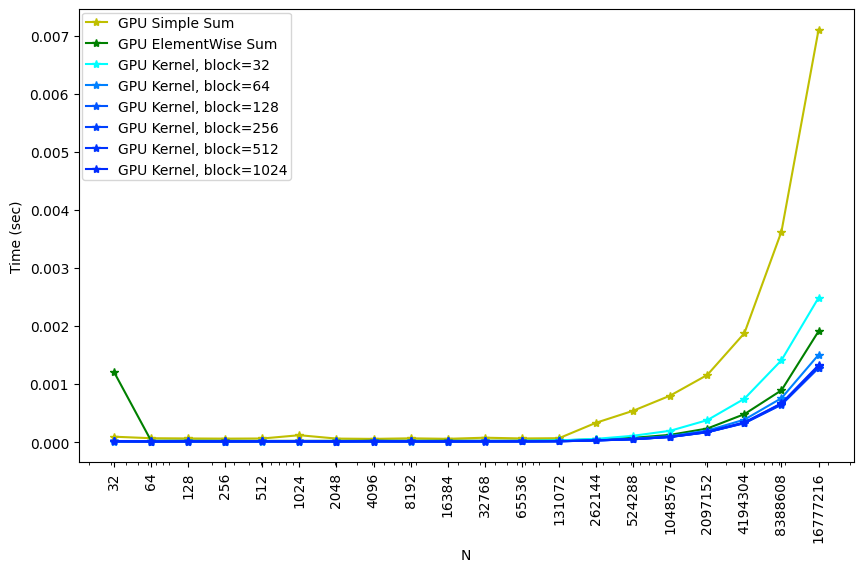

In [161]:
plt.figure(1,figsize=(10,6),dpi=100)
plt.semilogx(dimension,timeGPU1,'y-*',label='GPU Simple Sum')
plt.semilogx(dimension,timeGPU2,'g-*',label='GPU ElementWise Sum')
count = 0
for nt in [32,64,128,256,512,1024]:
    plt.semilogx(dimension,timeGPU3[count],'-*',label='GPU Kernel, block={0}'.format(nt),color=(0,1./(count+1),1))
    count+=1
plt.ylabel('Time (sec)')
plt.xlabel('N')
plt.xticks(dimension, dimension, rotation='vertical')
plt.legend(loc=2,labelspacing=0.5,fancybox=True, handlelength=1.5, borderaxespad=0.25, borderpad=0.25)

# Numba


prova


In [164]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


E' necessario far trovare due librerie che normalmente non sono nel path 

In [167]:
import os
os.environ['NUMBAPRO_LIBDEVICE'] = "/usr/local/cuda-10.0/nvvm/libdevice"
os.environ['NUMBAPRO_NVVM'] = "/usr/local/cuda-10.0/nvvm/lib64/libnvvm.so"


abbiamo già visto che numpy sfrutta il fatto che molte funzioni (ufunc, universal functions) sono compilate in C e aggiscono sugli elementi dei vettori in maniera automatia. Nel seguente esempio confrontiamo le performance di numpy con quelle della normale radice quadrata su opportuni vettori

In [169]:
import numpy as np

In [23]:
import math
x = np.arange(int(1e7), dtype=np.float32)
%timeit np.sqrt(x)
%timeit [math.sqrt(xx) for xx in x]

100 loops, best of 5: 9.55 ms per loop
1 loop, best of 5: 2.79 s per loop


proviamo a compilare una funzione utente con numba. Per far questo usiamo il decoratore @vectorize 

In [24]:
import math
import numpy as np
from numba import vectorize 
@vectorize
def cpu_sqrt(x):
  return math.sqrt(x)

%timeit cpu_sqrt(x)

The slowest run took 7.48 times longer than the fastest. This could mean that an intermediate result is being cached.
100 loops, best of 5: 10.7 ms per loop


proviamo ora a fare una versione GPU in cui la ufunc è compilata per le essere eseguita sulla GPU. A differenza della funzione CPU è necessario specificare i tipi di output e input nel decoratore: output(input). L'array di input deve avere il tipo corretto.

In [25]:
@vectorize(['float32(float32)'], target='cuda')
def gpu_sqrt(x):
    return math.sqrt(x)

In [26]:

%timeit gpu_sqrt(x)

The slowest run took 9.24 times longer than the fastest. This could mean that an intermediate result is being cached.
10 loops, best of 5: 18.9 ms per loop


apparentemente la versione GPU è piu' lenta della versione CPU. La ragione di questo è che l'operazione che stiamo facendo è troppo semplice e quindi non abbiamo vantaggio computazionale rispetto all'overhead di copiatura dell'array sul device.

facciamo un esempio piu' complicato. Generiamo dei punti in 2D con correlazione.

In [27]:
points = np.random.multivariate_normal([0,0], [[1.,0.9], [0.9,1.]], 1000).astype(np.float32)

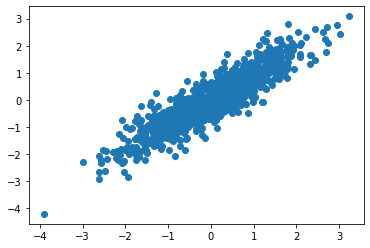

In [28]:
import matplotlib.pyplot as plt
plt.scatter(points[:,0], points[:,1])

ora proviamo a trasformare in coordinate polari

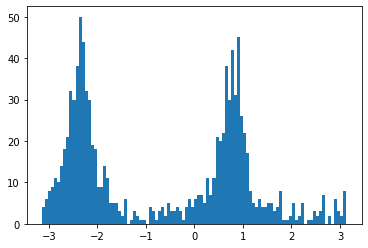

In [33]:
theta = np.arctan2(points[:,1], points[:,0]) 
_ = plt.hist(theta, bins=100)

vediamo 2 picchi perchè la correlazione puo' essere pi/4 o 3/4 pi. Proviamo a fare la stessa cosa con la GPU. Definiamo una ufunc gpu

In [34]:
@vectorize(['float32(float32, float32)'],target='cuda')
def gpu_arctan2(y, x): 
    theta = math.atan2(y,x)
    return theta

In [35]:
theta = gpu_arctan2(points[:,1], points[:,0])

ValueError: ignored

non funziona perchè le slice che abbiamo considerato non sono valori contigui in memoria, invece si devono passare array contigui come argomento. Per fortuna c'è una funzione per renderli contigui.

In [36]:
x = np.ascontiguousarray(points[:,0])
y = np.ascontiguousarray(points[:,1])

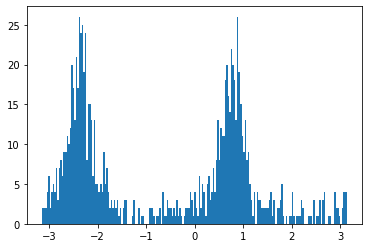

In [37]:
theta = gpu_arctan2(y, x)
_ = plt.hist(theta, bins=200)

funziona. Proviamo a farlo con piu' punti

In [38]:
points = np.random.multivariate_normal([0,0], [[1.,0.9], [0.9,1.]], int(1e7)).astype(np.float32)
x = np.ascontiguousarray(points[:,0])
y = np.ascontiguousarray(points[:,1])

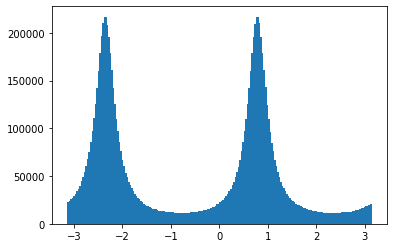

In [39]:
_ = plt.hist(gpu_arctan2(y, x), bins=200)

quantifichiamo il tempo

In [40]:
%timeit np.arctan2(y, x)


1 loop, best of 5: 340 ms per loop


In [41]:
%timeit gpu_arctan2(y, x)

10 loops, best of 5: 28.8 ms per loop


visto che ci siamo confrontiamo anche con plain python

In [42]:
%timeit [math.atan2(point[1], point[0]) for point in points]

1 loop, best of 5: 7.58 s per loop


Nelle ufunc (su GPU o meno) che abbiamo visto fino ad ora, l'argomento è un array e il risultato è un array di scalari delle stesse dimensioni ottenuto applicando una funzione su ogni elemento dell'array di input. Vogliamo generalizzare questa cosa permettendo cosa piu' complicate, come il fatto che il calcolo avvenga solo su una parte dell'array di input e che l'output possa essere anche un array di dimensioni differenti da quello di input. Si usa guvectorize

In [53]:
from numba import guvectorize

@guvectorize(['(float32[:], float32[:])'],
             '(n)->(n)',                
             target='cuda')
def gpu_polar(vec, out):
    x = vec[0]
    y = vec[1]
    out[0] = math.sqrt(x**2 + y**2)
    out[1] = math.atan2(y,x)

In [50]:
polar_coords = gpu_polar(points)

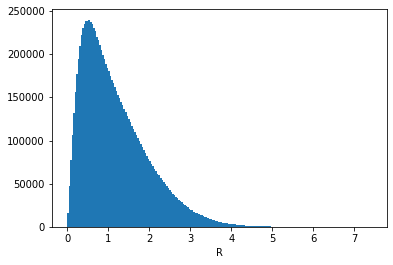

In [51]:
_ = plt.hist(polar_coords[:,0], bins=200)
_ = plt.xlabel('R')

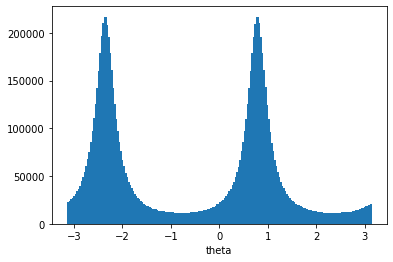

In [54]:
_ = plt.hist(polar_coords[:,1], bins=200)
_ = plt.xlabel('theta')

facciamo un altro esempio su guvectorize, ovvero la media per righe in un vettore 2D

In [59]:
@guvectorize(['(float32[:], float32[:])'],
             '(n)->()',                
             target='cuda')
def gpu_average(array, out):
    acc = 0
    for val in array: 
        acc += val
    out[0] = acc/len(array)
    print(len(array))

definiamo il vettore 2D

In [60]:
a = np.arange(100).reshape(20, 5).astype(np.float32)
a

array([[ 0.,  1.,  2.,  3.,  4.],
       [ 5.,  6.,  7.,  8.,  9.],
       [10., 11., 12., 13., 14.],
       [15., 16., 17., 18., 19.],
       [20., 21., 22., 23., 24.],
       [25., 26., 27., 28., 29.],
       [30., 31., 32., 33., 34.],
       [35., 36., 37., 38., 39.],
       [40., 41., 42., 43., 44.],
       [45., 46., 47., 48., 49.],
       [50., 51., 52., 53., 54.],
       [55., 56., 57., 58., 59.],
       [60., 61., 62., 63., 64.],
       [65., 66., 67., 68., 69.],
       [70., 71., 72., 73., 74.],
       [75., 76., 77., 78., 79.],
       [80., 81., 82., 83., 84.],
       [85., 86., 87., 88., 89.],
       [90., 91., 92., 93., 94.],
       [95., 96., 97., 98., 99.]], dtype=float32)

In [61]:
gpu_average(a)

array([ 2.,  7., 12., 17., 22., 27., 32., 37., 42., 47., 52., 57., 62.,
       67., 72., 77., 82., 87., 92., 97.], dtype=float32)

# Generare il PDF del Notebook

In [65]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

Reading package lists... Done
Building dependency tree       
Reading state information... Done
pandoc is already the newest version (1.19.2.4~dfsg-1build4).
pandoc set to manually installed.
The following additional packages will be installed:
  fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono fonts-texgyre
  javascript-common libcupsfilters1 libcupsimage2 libgs9 libgs9-common
  libijs-0.35 libjbig2dec0 libjs-jquery libkpathsea6 libpotrace0 libptexenc1
  libruby2.5 libsynctex1 libtexlua52 libtexluajit2 libzzip-0-13 lmodern
  poppler-data preview-latex-style rake ruby ruby-did-you-mean ruby-minitest
  ruby-net-telnet ruby-power-assert ruby-test-unit ruby2.5
  rubygems-integration t1utils tex-common tex-gyre texlive-base
  texlive-binaries texlive-fonts-recommended texlive-latex-base
  texlive-latex-recommended texlive-pictures texlive-plain-generic tipa
Suggested packages:
  fonts-noto apache2 | lighttpd | httpd poppler-utils ghostscript
  fonts-japanese-mincho | fonts-ipa

si deve montare il proprio google drive (seguire il link per ottenere la chiave di accesso)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

si deve copiare il notebook nella directory della macchina virtuale

In [ ]:
!cp "drive/My Drive/Colab Notebooks/handson_gpu_2021.ipynb" ./

ora si puo' convertire in pdf

In [ ]:
!jupyter nbconvert --to PDF "handson_gpu_2020.ipynb"

scaricare il file pdf prodotto dal menu files nel pannelo di sinistra (premere il destro sul file e fare download)